Steane code error correction using software with noise
=============================================

1. Set up logical zero and logical one for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla and measure the outputs.

3. Use ancilla measurements to correct the data using Python code and check that without noise all errors are corrected 

The simulation is run both with and without noise and the logical zero and logical one state are simulated.

There is an option to remove transpilation to assess the sensitivity.

Import the necessary function modules, including the SteaneCodeLogicalQubit class and helper functions.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    correct_qubit,
    flip_code_words,
    get_noise,
    mean_of_list,
    calculate_standard_error,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
TRANSPILE = False             # controls if transpilation takes place to allow sensitivity check
TITLE = 'Simulation before and after correction'

# transpilation uses a different gate set
if TRANSPILE:
    SINGLE_GATE_SET = ['id', 'ry', 'rx']
    TWO_GATE_SET = ['rxx']
else:
    SINGLE_GATE_SET = ['id', 'x', 'y', 'z', 'h']
    TWO_GATE_SET = ['cx', 'cz']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

DATA_QUBITS = 7
ANCILLA_QUBITS = 3

ERROR_REDUCTION = 1
SHOTS = 10000                                             #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise 
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION           #Two gate noise  
ITERATIONS = 25

SPACE = ' '
SIMULATOR = Aer.get_backend('qasm_simulator')

#graph constants
YMIN = -1.0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.2
GAP = 1.5
BAR_WIDTH = 10
CAPSIZE = 20

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Error correction
-----------------------

The ancilla error detection circuit is added to the encoding circuit and transpiled if required.  Noise is applied and the error rate before is calculated.  Then, the ancilla measurements are used to correct the data measurement in software and the error rate after correction is calculated. 

In [5]:
#set up scenarios
scenarios = {
        'Logical_zero, no noise, standard decoding':{
            'Logical_one' : False, 'Noise' : False, 'ps' : False, 'simple' : False
            },
        'Logical_zero, noise, standard decoding':{
            'Logical_one' : False, 'Noise' : True,  'ps' : False, 'simple' : False, 'offset' : 0
            },
        'Logical_one, no noise, standard decoding':{
            'Logical_one' : True, 'Noise' : False,  'ps' : False, 'simple' : False, 
            },
        'Logical_one, noise, standard decoding':{
            'Logical_one' : True, 'Noise' : True,  'ps' : False, 'simple' : False, 'offset' : 1
            },
        'Logical_zero, no noise, simple decoding':{
            'Logical_one' : False, 'Noise' : False, 'ps' : False, 'simple' : True
            },
        'Logical_zero, noise, simple decoding':{
            'Logical_one' : False, 'Noise' : True,  'ps' : False, 'simple' : True, 'offset' : 4
            },
        'Logical_one, no noise, simple decoding':{
            'Logical_one' : True, 'Noise' : False,  'ps' : False, 'simple' : True
            },
        'Logical_one, noise, simple decoding':{
            'Logical_one' : True, 'Noise' : True,  'ps' : False, 'simple' : True, 'offset' : 5
            },
        'Logical_zero, no noise, PS':{
            'Logical_one' : False, 'Noise' : False, 'ps' : True, 'simple' : False
            },
        'Logical_zero, noise, PS':{
            'Logical_one' : False, 'Noise' : True,  'ps' : True, 'simple' : False, 'offset' : 2
            },
        'Logical_one, no noise, PS':{
            'Logical_one' : True, 'Noise' : False,  'ps' : True, 'simple' : False
            },
        'Logical_one, noise, PS':{
            'Logical_one' : True, 'Noise' : True,  'ps' : True, 'simple' : False, 'offset' : 3
            },
        }

In [6]:
def set_up_circuit(logical_one):
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords)
    qubit.set_up_logical_zero(logical_one = logical_one)
    qubit.barrier()  
    qubit.barrier()
    qubit.set_up_ancilla()
    qubit.barrier()
    qubit.logical_measure_data()
    qubit.logical_measure_ancilla()
    qubit.barrier()
    return(qubit)

In [7]:
def calculate_error_rate(counts, codewords, logical_one, ps, si):
    if logical_one:
        #follow Egan's sign convention
        sign = -1
        if si:
            valid_codewords = '1'
        else:
            valid_codewords = flip_code_words(codewords)
    else:
        #logical zero
        sign = 1
        if si:
            valid_codewords = '0'
        else:
            valid_codewords = codewords
    _ , count_invalid, _ = count_valid_output_strings(counts, valid_codewords, 
                                                      data_location = 2,
                                                      post_selection = ps,
                                                      simple = si)
    error_rate = sign * count_invalid / SHOTS
    return(error_rate)

In [8]:
def compute_new_count(counts):
    new_counts = {}
    for key, values in counts.items():
    #split out components of counts
    # X ancilla
        key0 = key.split()[0]
        # Z ancilla
        key1 = key.split()[1]
        #data qubits
        key2 = key.split()[2]
        new_key2 = correct_qubit(key2, key0, DATA_QUBITS)
        new_key = key0 + SPACE + key1 + SPACE + new_key2        
        if new_counts.get(new_key) == None: 
            new_counts.update({new_key: values})
        else:
            new_counts[new_key] = new_counts[new_key] + values
    return(new_counts)

In [9]:
#initialise lists for graphs results
values_list = [[] for i in range(6)]
standard_error_list = [[] for i in range(6)]
labels_list = ['0L','1L']
cases_list = ['No_error_correction','Error_correction']
noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, 
                        SINGLE_GATE_SET, TWO_GATE_SET )

In [10]:
if TRANSPILE:
    print('Transpilation has been carried out')
else:
    print('Transpilation has NOT been carried out')
print()

for cases, parameters in scenarios.items():
    print(f'For case {cases}')
    logical_one = parameters.get('Logical_one')
    noise = parameters.get('Noise')
    ps = parameters.get('ps')
    simple = parameters.get('simple')
    error_rate_before_list = []
    error_rate_after_list = []
    for iteration in range(ITERATIONS):
        qubit = set_up_circuit(logical_one)
        if TRANSPILE:
            qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
            if noise:
                result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qt, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qt)
        else:
            if noise:
                result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qubit, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qubit)
        error_rate = calculate_error_rate(counts, codewords, logical_one, ps, simple)
        error_rate_before_list.append(error_rate)
        new_counts = compute_new_count(counts)
        error_rate = calculate_error_rate(new_counts, codewords, logical_one, ps, simple)        
        error_rate_after_list.append(error_rate)
    mean_error_rate_before = mean_of_list(error_rate_before_list)
    standard_deviation_before, standard_error_before = calculate_standard_error(error_rate_before_list)
    print(f'The mean invalid error rate before correction is {mean_error_rate_before:.5f}')
    print(f'The standard error before correction is {standard_error_before:.5f}')
    mean_error_rate_after = mean_of_list(error_rate_after_list) 
    standard_deviation_after, standard_error_after = calculate_standard_error(error_rate_after_list)
    print(f'The mean invalid error rate after correction is {mean_error_rate_after:.5f}')
    print(f'The standard error after correction is {standard_error_after:.5f}')
    if noise:
        #calculate which value list to update
        offset = parameters.get('offset')
        values_list[offset].append(mean_error_rate_before)
        values_list[offset].append(mean_error_rate_after)
        standard_error_list[offset].append(standard_error_before)
        standard_error_list[offset].append(standard_error_after)    
    print()

Transpilation has NOT been carried out

For case Logical_zero, no noise, standard decoding
The mean invalid error rate before correction is 0.00000
The standard error before correction is 0.00000
The mean invalid error rate after correction is 0.00000
The standard error after correction is 0.00000

For case Logical_zero, noise, standard decoding
The mean invalid error rate before correction is 0.42423
The standard error before correction is 0.00096
The mean invalid error rate after correction is 0.32196
The standard error after correction is 0.00098

For case Logical_one, no noise, standard decoding
The mean invalid error rate before correction is 0.00000
The standard error before correction is 0.00000
The mean invalid error rate after correction is 0.00000
The standard error after correction is 0.00000

For case Logical_one, noise, standard decoding
The mean invalid error rate before correction is -0.45904
The standard error before correction is 0.00097
The mean invalid error rate aft

In [11]:
def plot_graph(offset, title):
    #graph with no PS
    fig, ax = plt.subplots()
    x = np.arange(len(cases_list))  # the label locations
    plt.bar(x - WIDTH, values_list[offset], color = '#cc5000', width = WIDTH * GAP, label = labels_list[0])
    plt.bar(x + WIDTH, values_list[offset + 1 ], color = '#5000cc', width = WIDTH * GAP, label = labels_list[1])
    plt.errorbar(x - WIDTH, values_list[offset], yerr = standard_error_list[offset], 
                 color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )
    plt.errorbar(x + WIDTH, values_list[offset + 1], yerr = standard_error_list[offset + 1], 
                 color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )

    ax.set_ylabel('Ancilla Population')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(cases_list)
    ax.legend()

    plt.ylim(YMIN, YMAX)
    plt.yticks(np.arange(YMIN, YMAX, YTICK))

    fig.tight_layout()

    fname = './graphs/' + title
    plt.savefig(fname)

Print out graph showing results

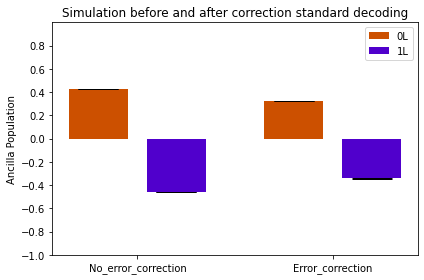

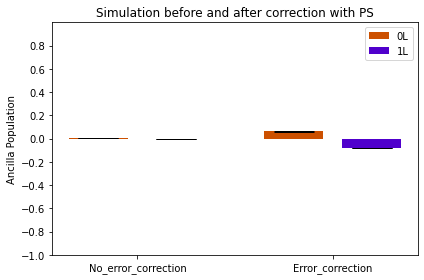

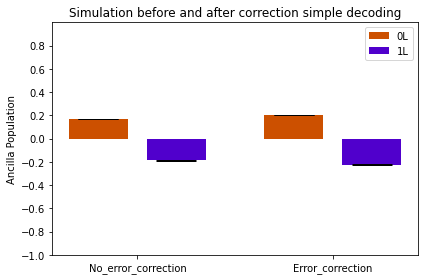

In [12]:
graphs = {' standard decoding' : 0,
          ' with PS' : 2,
          ' simple decoding' : 4
         }
for title, offset in graphs.items():
    title = TITLE + title
    plot_graph(offset, title)

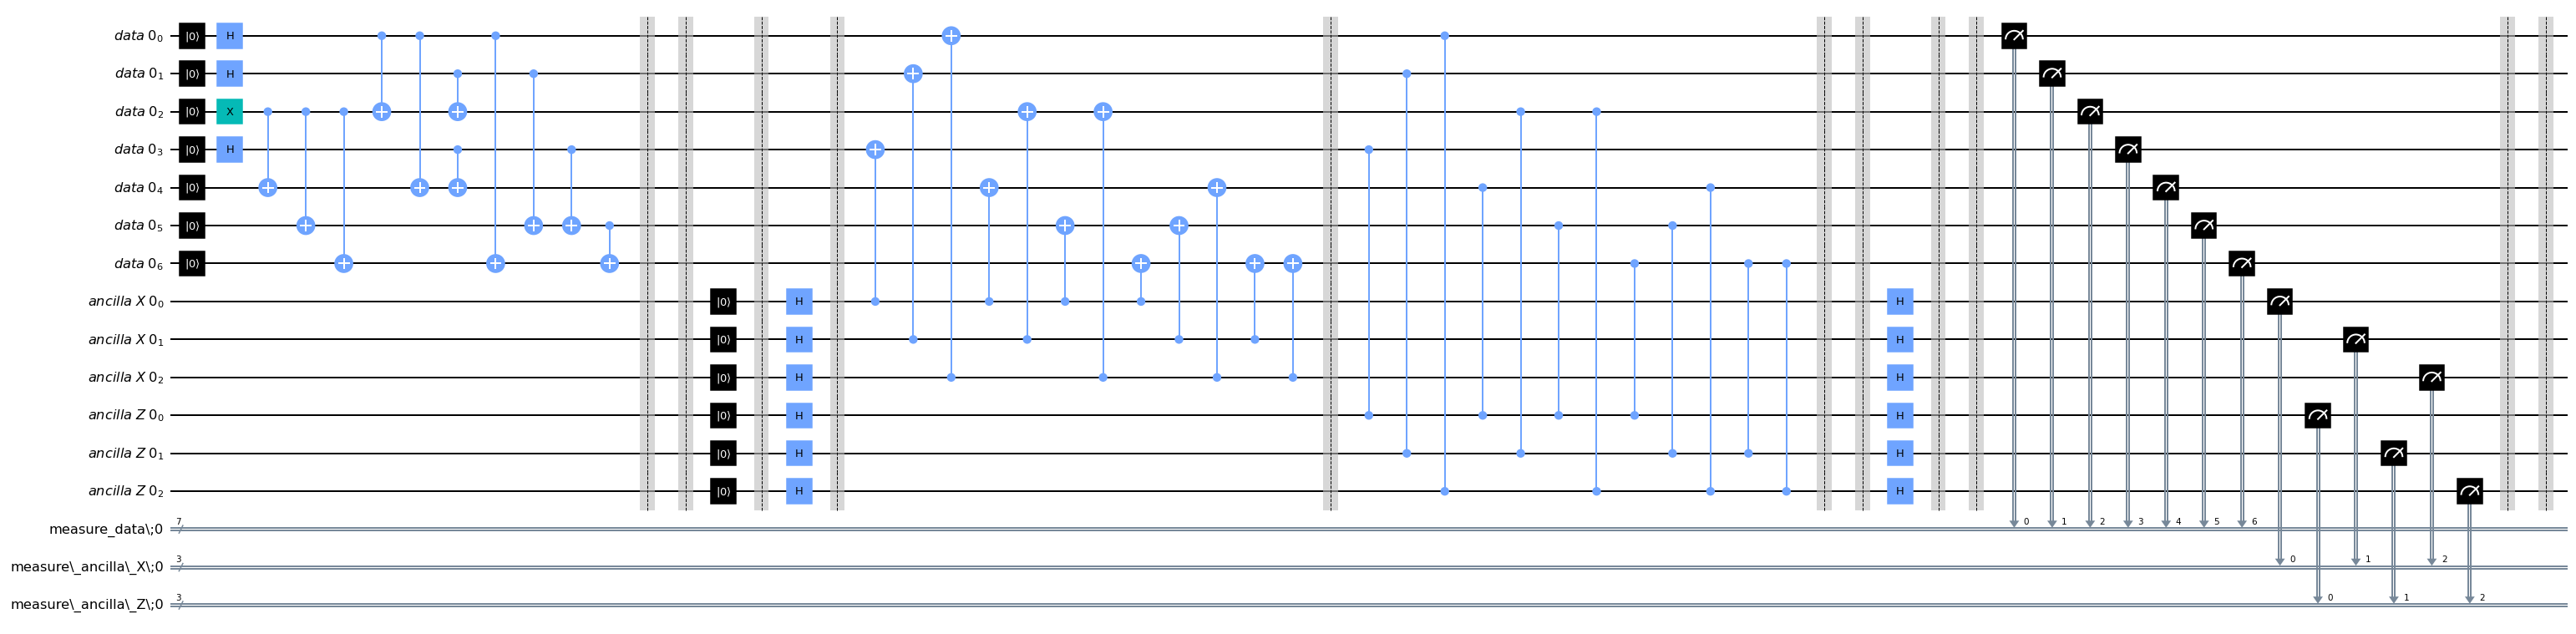

In [13]:
qubit.draw(output = 'mpl', filename = './circuits/Steane_code_error_detection_circuit.jpg', fold = 63)

In [14]:
if TRANSPILE:
    qt.draw(output = 'mpl', filename = './circuits/Steane_code_error_detection_circuit_transpiled.jpg', fold = 60)